# RoBERTa Training

## Import packages and read data

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
import torch
import re
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from transformers import RobertaTokenizer, RobertaForSequenceClassification, get_linear_schedule_with_warmup
from collections import defaultdict, Counter
from sklearn.preprocessing import LabelEncoder


sns.set_theme()


# Torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
train_df = pd.read_json(path_or_buf=r'.\scicite\train.jsonl', lines=True)
test_df = pd.read_json(path_or_buf=r'.\scicite\test.jsonl', lines=True)
val_df = pd.read_json(path_or_buf=r'.\scicite\dev.jsonl', lines=True)

## Quick EDA

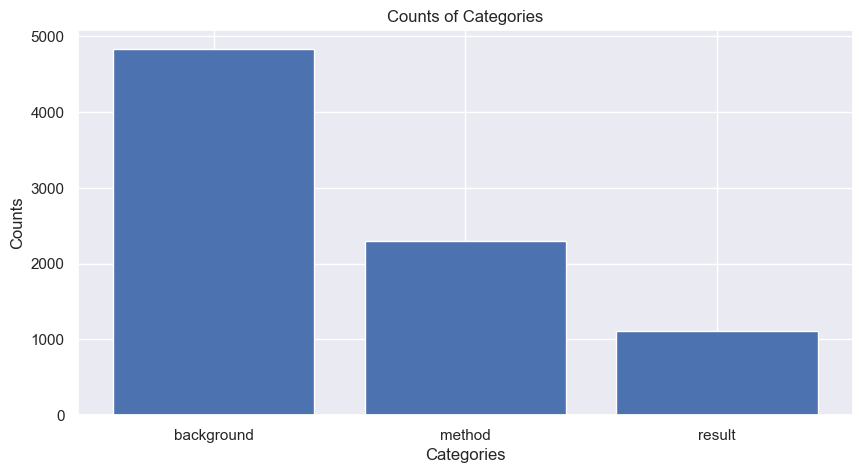

Max number of words:  505
Max chars:  3327


Token indices sequence length is longer than the specified maximum sequence length for this model (527 > 512). Running this sequence through the model will result in indexing errors


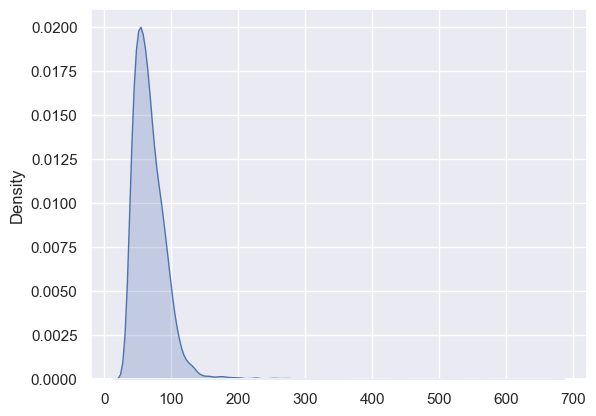

In [43]:
# Quick EDA
categories = train_df['label'].values.reshape(-1)
counter_categories = Counter(categories)
category_names = counter_categories.keys()
category_counts = counter_categories.values()

# Graph
plt.figure(figsize=(10, 5))
plt.bar(category_names, category_counts)
plt.xlabel('Categories')
plt.ylabel('Counts')
plt.title('Counts of Categories')
plt.show()

# Check longest number of words
longest_string = 0
for string in train_df['string']:
    longest_string = max(longest_string, len(string.split()))
print("Max number of words: ", longest_string)

# Check longest number of characters
max_chars = 0
for string in train_df['string']:
    max_chars = max(max_chars, len(string))
print("Max chars: ", max_chars)

# Check for distribution of number of words
# plot = sns.kdeplot(train_df['string'].apply(lambda x: len(x.split())), fill=True)
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', do_lower_case=True)
text_lens = list()
for t in train_df['x'].values:
    a = tokenizer.encode(t)
    text_lens.append(len(a))
sns.kdeplot(text_lens, fill=True)
plt.show()

## Setup

In [44]:
## Roberta
max_length = 200

# Tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', do_lower_case=True)
X_train = train_df[feature_name].values
X_train_encoded = tokenizer.batch_encode_plus(X_train.tolist(), 
                                              pad_to_max_length=True, 
                                              max_length=max_length, 
                                              return_tensors='pt', 
                                              truncation=True)
X_test = test_df[feature_name].values
X_test_encoded = tokenizer.batch_encode_plus(X_test.tolist(), 
                                              pad_to_max_length=True, 
                                              max_length=max_length, 
                                              return_tensors='pt', 
                                              truncation=True)
X_val = val_df[feature_name].values
X_val_encoded = tokenizer.batch_encode_plus(X_val.tolist(), 
                                              pad_to_max_length=True, 
                                              max_length=max_length, 
                                              return_tensors='pt', 
                                              truncation=True)

# Label Encoder
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_df['label'].values)
y_train = torch.tensor(y_train)
# print(y_train.unique())
y_test = label_encoder.transform(test_df['label'].values)
y_test = torch.tensor(y_test)
y_val = label_encoder.transform(val_df['label'].values)
y_val = torch.tensor(y_val)

C:\Users\foong\miniconda3\envs\datasci\lib\site-packages\transformers\tokenization_utils_base.py:2619: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [75]:
# Create dataset
batch_size = 32
train_dataset = torch.utils.data.TensorDataset(X_train_encoded['input_ids'], X_train_encoded['attention_mask'], y_train)
train_dataloader = torch.utils.data.DataLoader(train_dataset, 
                                               sampler=torch.utils.data.RandomSampler(train_dataset), 
                                               batch_size=batch_size)
test_dataset = torch.utils.data.TensorDataset(X_test_encoded['input_ids'], X_test_encoded['attention_mask'], y_test)
test_dataloader = torch.utils.data.DataLoader(test_dataset, 
                                              sampler=torch.utils.data.SequentialSampler(test_dataset), 
                                              batch_size=batch_size)
val_dataset = torch.utils.data.TensorDataset(X_val_encoded['input_ids'], X_val_encoded['attention_mask'], y_val)
val_dataloader = torch.utils.data.DataLoader(val_dataset, 
                                              sampler=torch.utils.data.SequentialSampler(val_dataset), 
                                              batch_size=batch_size)

In [76]:
# Model
model = RobertaForSequenceClassification.from_pretrained('roberta-base',
                                                         num_labels = len(label_encoder.classes_),
                                                         output_attentions = False,
                                                         output_hidden_states = False)
model.to(device)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [77]:
def accuracy(preds,labels):
    pred_flat = np.argmax(preds,axis=1).flatten()
    label_flat = labels.flatten()
    return np.sum(pred_flat==label_flat)/len(label_flat)

def evaluate(dataloader_test):
    model.eval()
    loss_val_total = 0
    predictions,true_vals = [],[]
    for batch in dataloader_test:
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        batch[2] = batch[2].type(torch.LongTensor)   # casting to long
        labels = batch[2].to(device)
        
        inputs = {'input_ids':      input_ids,
                  'attention_mask': attention_mask,
                  'labels':         labels,
                 }
        with torch.no_grad():
            outputs = model(**inputs)
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()
        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    loss_val_avg = loss_val_total / len(dataloader_test)
    predictions = np.concatenate(predictions,axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
    return loss_val_avg, predictions, true_vals

class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

## Training

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr = 2e-5, betas=(0.9, 0.98), eps=1e-6)

epochs = 10
total_steps = len(train_dataloader)*epochs
scheduler = get_linear_schedule_with_warmup(optimizer,num_warmup_steps=0,
                                           num_training_steps=total_steps)

torch.cuda.empty_cache()
early_stopper = EarlyStopper(patience=3, min_delta=10)
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(train_dataloader, desc='Epoch {:1d}'.format(epoch), leave=True, disable=False, position=0)
    for batch in progress_bar:

        model.zero_grad()
        
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        batch[2] = batch[2].type(torch.LongTensor)   # casting to long
        labels = batch[2].to(device)
        
        inputs = {'input_ids':      input_ids,
                  'attention_mask': attention_mask,
                  'labels':         labels,
                 }

        outputs = model(**inputs)
        loss = outputs.loss
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(train_dataloader)            
    tqdm.write(f'Training loss: {loss_train_avg}')

    train_loss, predictions, true_vals = evaluate(train_dataloader)
    train_acc = accuracy(predictions, true_vals)
    tqdm.write(f'Training loss: {train_loss}')
    tqdm.write(f'Accuracy: {train_acc}')
    
    val_loss, predictions, true_vals = evaluate(val_dataloader)
    val_acc = accuracy(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'Accuracy: {val_acc}')
    
    test_loss, predictions, true_vals = evaluate(test_dataloader)
    test_acc = accuracy(predictions, true_vals)
    tqdm.write(f'Test loss: {test_loss}')
    tqdm.write(f'Accuracy: {test_acc}')
    
    if early_stopper.early_stop(val_loss):
        print("Early stopped.")
        break